<a href="https://colab.research.google.com/github/worsrp/K-pop-Female-Idol-Faces-Classification/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation
connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing


In [3]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import os

def extract_face(filename, size):
    # load image from file
    required_size=(size, size)
    image = Image.open(filename)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def load_face(dir, require_size):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path, require_size)
        faces.append(face)
    return faces

def extract_dataset(dir, require_size):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path, require_size)
        labels = [subdir for i in range(len(faces))]
        # print progress
        print("loaded samples for class: %s" % subdir) 
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

def load_dataset(require_size) :
  # load train dataset
  train_x, train_y = extract_dataset('/content/drive/MyDrive/dataset/KID-F/train/', require_size)
  # load test dataset
  test_x, test_y = extract_dataset('/content/drive/MyDrive/dataset/KID-F/test/', require_size)

  train_x = np.array(train_x)
  train_y = np.array(train_y)
  test_x = np.array(test_x)
  test_y = np.array(test_y)
  train_x = train_x.astype('float32')
  test_x = test_x.astype('float32')

  train_x /= 255
  test_x /= 255

  return train_x, train_y, test_x, test_y

def create_one_hot(train_y,test_y):
  total_label = np.array(list(set(train_y)))
  train_mapping = np.array(train_y)
  test_mapping = np.array(test_y)

  # map each label to an integer
  mapping = {}
  for i in range(len(total_label)):
    mapping[total_label[i]] = i

  # integer representation
  for i in range(len(train_y)):
    train_mapping[i] = mapping[train_mapping[i]]

  for i in range(len(test_y)):
    test_mapping[i] = mapping[test_mapping[i]]

  one_hot_train = to_categorical(train_mapping, num_classes=55)
  one_hot_test = to_categorical(test_mapping, num_classes=55)

  return one_hot_train, one_hot_test, total_label

def create_dataset(require_size):
  train_x, train_y, test_x, test_y = load_dataset(require_size)
  one_hot_train, one_hot_test, total_label = create_one_hot(train_y,test_y)

  # split training set and validation set
  train_x, validate_x, one_hot_train, one_hot_validate = train_test_split(np.array(train_x), np.array(one_hot_train), test_size=0.1, shuffle= True)
  
  return train_x, validate_x, test_x, test_y, one_hot_train, one_hot_validate, one_hot_test, total_label     

In [4]:
train_x, validate_x, test_x, test_y, one_hot_train, one_hot_validate, one_hot_test, total_label = create_dataset(150)

loaded samples for class: minyoung
loaded samples for class: jihyo
loaded samples for class: wonyoung
loaded samples for class: rei
loaded samples for class: choilee
loaded samples for class: jeongyeon
loaded samples for class: kimchaewon
loaded samples for class: mina
loaded samples for class: joyuri
loaded samples for class: jisoo
loaded samples for class: sunny
loaded samples for class: bravegirls_yuna
loaded samples for class: le
loaded samples for class: jennie
loaded samples for class: kwoneunbi
loaded samples for class: nayeon
loaded samples for class: kanghyewon
loaded samples for class: giselle
loaded samples for class: hongeunchae
loaded samples for class: hondahitomi
loaded samples for class: yujin
loaded samples for class: bravegirls_eunji
loaded samples for class: kimminju
loaded samples for class: bravegirls_yujeong
loaded samples for class: sana
loaded samples for class: ningning
loaded samples for class: yeri
loaded samples for class: hyolin
loaded samples for class: ro

# Training Phase


### initialize hyperparameter

In [5]:
import keras
import tensorflow as tf
from keras.models import load_model

NUM_CLASSES = 55
LEARN_RATE = 0.01
MOMENTUM = 0.9
BATCH_SIZE = 128
EPOCHS = 10

### load pretrained model

In [6]:
base_model = keras.applications.Xception(weights='imagenet', 
                              include_top=False, 
                              input_shape=(150, 150, 3))
base_model.load_weights('/content/drive/MyDrive/NNmodel/xception.h5')

### initialize neural network

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

xception = keras.Sequential([
        base_model,
        
        keras.layers.Dropout(0.20),
        keras.layers.Flatten(),
        keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [8]:
xception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 55)                2816055   
                                                                 
Total params: 23,677,535
Trainable params: 23,623,007
Non-trainable params: 54,528
_________________________________________________________________


### set up optimizer and loss function

In [9]:
sgd_opt = keras.optimizers.SGD(learning_rate=LEARN_RATE, momentum=MOMENTUM)
cce_loss = keras.losses.categorical_crossentropy

### train model

In [10]:
xception.compile(optimizer=sgd_opt, loss=cce_loss, metrics=['accuracy'])

In [11]:
train_history = xception.fit(train_x, one_hot_train ,batch_size=BATCH_SIZE, epochs=EPOCHS ,validation_data=(validate_x, one_hot_validate))

Epoch 1/10
40/40 [==============================] - 62s 1s/step - loss: 2.4411 - accuracy: 0.4496 - val_loss: 3.2240 - val_accuracy: 0.1964
Epoch 2/10
40/40 [==============================] - 41s 1s/step - loss: 1.0910 - accuracy: 0.7150 - val_loss: 2.5043 - val_accuracy: 0.3661
Epoch 3/10
40/40 [==============================] - 42s 1s/step - loss: 0.5336 - accuracy: 0.8521 - val_loss: 1.6637 - val_accuracy: 0.6125
Epoch 4/10
40/40 [==============================] - 42s 1s/step - loss: 0.2391 - accuracy: 0.9374 - val_loss: 1.5742 - val_accuracy: 0.6786
Epoch 5/10
40/40 [==============================] - 44s 1s/step - loss: 0.0916 - accuracy: 0.9809 - val_loss: 1.6255 - val_accuracy: 0.7018
Epoch 6/10
40/40 [==============================] - 44s 1s/step - loss: 0.0428 - accuracy: 0.9922 - val_loss: 1.4128 - val_accuracy: 0.7607
Epoch 7/10
40/40 [==============================] - 44s 1s/step - loss: 0.0299 - accuracy: 0.9948 - val_loss: 1.6246 - val_accuracy: 0.7179
Epoch 8/10
40/40 [==

### plot result

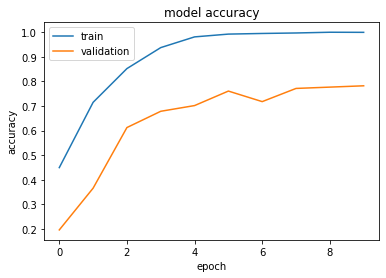

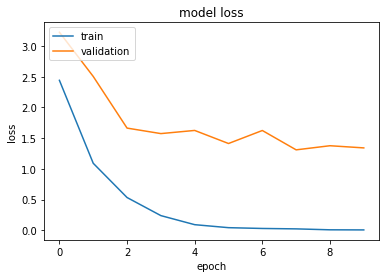

train acc_max: 0.9998012185096741
val acc_max: 0.7821428775787354
train loss_min: 0.006299164611846209
val loss_min: 1.3096435070037842


In [12]:
import matplotlib.pyplot as plt
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print("train acc_max:",max(train_history.history['accuracy']))
print("val acc_max:",max(train_history.history['val_accuracy']))
print("train loss_min:",min(train_history.history['loss']))
print("val loss_min:",min(train_history.history['val_loss']))


#Testing Phase

In [35]:
import random

correct = 0
test_len = len(test_x)
true_prediction = []
true_img = []
false_prediction = []
false_img = []

for i in range(test_len):
  img = test_x[i]
  expectation = test_y[i]
  p_img = np.reshape(img ,(1,150,150,3))

  prediction = xception.predict(p_img)
  label = total_label
  result = label[np.argmax(prediction)]

  if(result==expectation):
    correct += 1
  else:
    idx_arr = np.where(test_y == result)
    rand = random.randint(0, len(idx_arr))
    if(len(idx_arr[0])!=0):
      idx = idx_arr[0][rand]

      true_prediction.append(expectation)
      true_img.append(test_x[i])

      false_prediction.append(result)
      false_img.append(test_x[idx])

acc = correct/test_len

1/1 [==============================] - 0s 27ms/step


##Testing Accuracy

In [36]:
print('Testing accuracy: ', acc)

Testing accuracy:  0.8136363636363636


## Model Prediction Examples

1/1 [==============================] - 0s 21ms/step


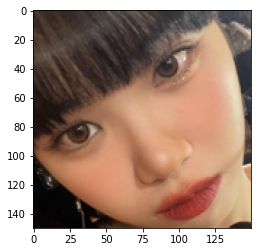

[[1.02969410e-04 1.43513738e-04 1.07598916e-08 3.64579558e-02
  1.80319615e-03 1.78367354e-05 8.13672423e-01 4.21842934e-08
  1.29270248e-08 3.95410243e-05 7.65645236e-09 7.00322786e-08
  4.77955915e-08 1.40647288e-07 6.03004555e-05 1.50811113e-03
  8.81523883e-04 5.64935920e-09 1.49912633e-08 1.07700157e-03
  7.89791255e-09 1.46580958e-09 4.62291126e-07 3.98107339e-04
  2.69142397e-08 7.07710569e-05 1.26789280e-04 1.27901912e-01
  5.42784855e-03 5.95874683e-09 9.49600079e-08 1.64131979e-08
  3.76002390e-07 1.26600055e-08 3.22260639e-05 1.37688658e-05
  1.01659424e-07 8.54469828e-09 5.56335319e-04 5.20563788e-08
  2.29075613e-05 1.89471219e-04 1.03582664e-07 1.98496704e-08
  7.11555913e-05 2.03500931e-05 2.98999803e-04 3.14969043e-07
  5.95278398e-04 2.04117941e-06 2.57510919e-07 1.44705128e-08
  1.93755092e-08 8.50520749e-03 2.36101656e-07]]
expectation: kimchaewon
prediction: kimchaewon


In [15]:
rand = random.randint(0, len(test_x))

img = test_x[rand]
expectation = test_y[rand]
p_img = np.reshape(img ,(1,150,150,3))

result = xception.predict(p_img)
label = total_label
prediction = label[np.argmax(result)]

plt.imshow(img)
plt.show()
print(result)
print('expectation: '+expectation)
print('prediction: '+prediction)

##False Prediction Examples

False prediction example 1


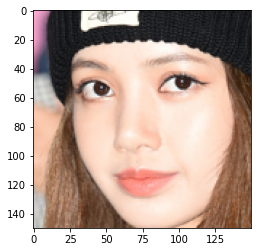

expectation: lisa


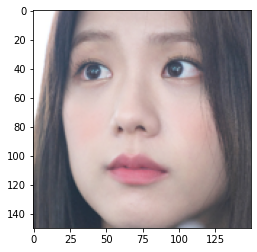

prediction: jisoo
False prediction example 2


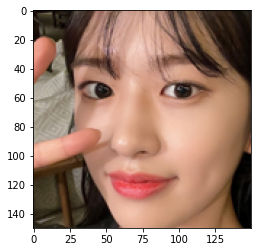

expectation: yujin


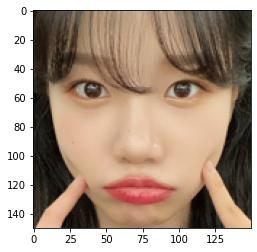

prediction: joyuri
False prediction example 3


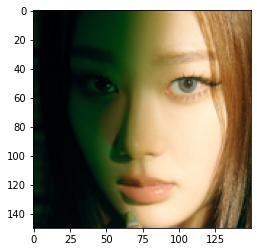

expectation: giselle


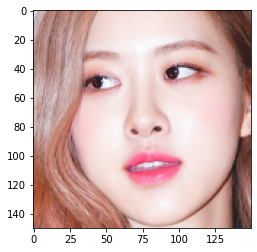

prediction: rose


In [46]:
for i in range (3):
  rand = random.randint(0, len(false_prediction))

  expectation = true_prediction[rand]
  prediction = false_prediction[rand]

  print('False prediction example',i+1)
  plt.imshow(true_img[rand])
  plt.show()
  print('expectation: '+expectation)
  plt.imshow(false_img[rand])
  plt.show()
  print('prediction: '+prediction)